# Limpieza de texto
### Creación de los dataframe y limpieza de texto

In [353]:
import pandas as pd
import numpy as np
from pprint import pprint

df = pd.read_csv('pericias_medicas.csv', sep=',',  encoding='utf-8')
#convierte en string los datos de la columna text
df1 = df['text'].apply(str)

In [354]:
import re
def general(txt: str, bert=False, nums=True) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))
        txt = re.sub(r'[^\w\s]', '', txt)

    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt

# Eliminación de expedientes que no son pericias médicas.

In [355]:
# Elimino expedientes que no son pericuas medicas
noPericiasMedicas=[]
for i,expediente in enumerate(df1):
    exp = general(expediente)
    if len(exp.split()) < 300:
        totalPalabras = len(exp.split())
        noPericiasMedicas.append((i, expediente, totalPalabras))
        df1 = df1.drop(i)

dfNoPericiasMedicas = pd.DataFrame(noPericiasMedicas,columns=['id','expediente', 'total de palabras'])

In [356]:
df1.reset_index(drop=True, inplace=True)

In [357]:
print(df.expediente[200])
print(df.descripcion[200])

CNT74807/2016
perito medico presenta informe pericial [presentado 12 01 2019 18 33]


In [358]:
print(df.expediente[3436])
print(df.descripcion[3436])

CNT49991/2016
perito psicologa presenta respuesta [presentado 03 09 2018 23 47]


In [359]:
print(df.expediente[2000])
print(df.descripcion[2000])

CNT11480/2016
perito informa  parte 1 de 2  [presentado 18 03 2019 16 42]


In [360]:
pprint(dfNoPericiasMedicas.expediente[7])

(' \n'
 '\n'
 ' \n'
 '\n'
 ' \n'
 '\n'
 ' \n'
 '\n'
 ' \n'
 '\n'
 ' \n'
 '\n'
 ' \n'
 '\n'
 'Juzgado Nacional del Trabajo nº 24 \n'
 '\n'
 'Diagonal Roque Sáenz Peña 760, 3ºP. \n'
 '\n'
 'OBSERVA PERICIA MEDICA - SOLICITA ACLARACIONES \n'
 '\n'
 'Señor Juez: \n'
 '\n'
 ' HORACIO  CESAR  MATEO,  Letrado  Inscripto  en  la  matrícula \n'
 '\n'
 'respectiva  T°68  F°555  C.P.A.C.F.,  D.N.I.  18.123.659,  CUIT:  '
 '20-18123659-1,  IVA: \n'
 '\n'
 'Responsable \n'
 '\n'
 'Inscripto, \n'
 '\n'
 'domicilio \n'
 '\n'
 'electronico \n'
 '\n'
 'CUIT \n'
 '\n'
 '20-18123659-1, \n'
 '\n'
 'info@estudiomateo.net,  en  mi  carácter  de  letrado  apoderado  de  la  '
 'parte  actora, \n'
 '\n'
 'manteniendo  domicilio  legal  físico  en  la  calle  Lavalle  N°  1388,  '
 'casillero  1301,  de  la \n'
 '\n'
 'Ciudad  Autónoma  de  Buenos  Aires,  en  los  autos  caratulados  '
 '"ZERRIZUELA,  JUAN \n'
 '\n'
 'OSCAR  C/  EXPERTA  ART  S.A.    s/  ACCIDENTE  -  LEY  ESPECIAL"  Expte.  '
 'Nº \n'
 '\n'


In [361]:
# Limpieza de texto
# Primera etapa de la limpieza de texto
import re, string, unicodedata
'''
Se hace la eliminacion de texto entre corchetes, acentos, signos de puntuacion (excepto . y :), palabras con numeros.
Se eliminan los espacios de sobra
Se eliminan \r, \t, \v, \f, \a
'''
def limpiarTexto1(txt: str, bert=False, nums=False) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))

    '''
    Eliminamos caracteres especiales: tabulador horizontal(\t), tabulador vertical(\v), 
    retorno de carro(\r), avance de pagina(\f), 
    caracter de retroceso: Marca el límite de una palabra(\b), 
    '''
    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt
df1 = df1.apply(str)
df1 = df1.apply(limpiarTexto1)

In [362]:
# Segunda fase de limpieza
# Se eliminan todos los elementos que meten ruido al texto y que no fueron eliminados en la fase de limpieza 1.
import re

def limpiarTexto2(text):
    text = re.sub('^ ',' ',text)
    text = re.sub('\n +\n','\n',text)
    text = re.sub(' +\n\n','\n',text)
    text = re.sub('\n\n+','\n',text)
    text = re.sub(' \n','\n',text)
    text = re.sub('\d\n','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('\u200b\n','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('\d+-\d+','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('[nN]º|[nN][. ]º','',text)
    text = re.sub('[º<>/]','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('[a-zA-z-.]+@[a-zA-Z]+.com','',text)
    return text

df1 = df1.apply(limpiarTexto2)

In [363]:
# Tercera fase de limpieza
# Eliminamos las lineas que no son de utilidad para el analisis o que van a afectar los resultados del mismo.
# Ejemplo de linea eliminada: las lineas que comienzan con "Se encuentra contestada en....."
import re

def limpiarTexto3(text):
    text = re.sub('[a-z1-9.]+[).-] [s|S]e encuentra contestad[a|o] .+[. \n]','',text)
    text = re.sub('[0-9]+[. ]+[yY]a fue contestado.+[.\n]','',text)
    text = re.sub('[fF]oja [1-9].+\n', '', text)
    text = re.sub('[pP]regunta[ 0-9]+[)].+\n|[rR]espuesta[ 0-9]+[)].+\n','',text)#elimina oraciones comenzadas en preguta/respuesta.
    text = re.sub('V[. ]+[S\n\.]+', '', text)
    #text = re.sub('[IV]+.[A-Z]{1,3}[\n.]', '', text)
    text = re.sub('[I][.][P][.]','',text)
    text = re.sub('[I][.][T][.]','',text)
    text = re.sub('[I][.][A][.]','',text)
    text = re.sub('[I][.][L][.]','',text)
    text = re.sub('[I][.][B][.]','',text)
    text = re.sub('[I][.][N][.]','',text)
    text = re.sub('[I][.][V][.]','',text)
    text = re.sub('[V][.][M][.]','',text)
    text = re.sub('[V][.][A][.]','',text)

    return text

dfLimpio = df1.apply(limpiarTexto3)
dfLimpio = dfLimpio.apply(limpiarTexto2)
#pprint(dfLimpio[0])

In [364]:
# limpiar titulos
def limpiar_palabras(text):
    text = re.sub(r'(I{1,3}|IV|V|VI{1,4}|IX|X)[). -]|[^\w\s]',' ',text)
    #text = re.sub(r'(i{1,3}|iv|v|vi{1,4}|ix|x)[). -]|[^\w\s]','',text)
    text=text.lower()
    text = [
        i for i in text.split() if len(i) > 3
    ]
    return ' '.join(text)

#### Eliminar stopwords

In [365]:
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    #texto = limpiar_palabras(texto)
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return ' '.join(texto)

# Busqueda de titulos

## Títulos con números romanos y en mayúsculas

In [366]:
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8:
            titulosMayusculasEncontrados.append(m.group())

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfLimpio:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)


# Creacion de dataframe de solo titulos en mayusculas

In [451]:
# Creamos un dataframe para guardar expedientes que solamente tienen titulos en mayusculas
# Guardo en dfTitulosMayusculas los expedientes y su indice dentro del dataframe limpio (con todos los expedientes)
expConTitulosMayusculas = []
expSinTitulosEncontrados = []
for id,titulo in  enumerate(dfLimpio):
    if len(titulosMayusculas[id]) > 0:
        expConTitulosMayusculas.append((id,titulo))
    else:
        expSinTitulosEncontrados.append((id,titulo))


dfTitulosMayusculas = pd.DataFrame(expConTitulosMayusculas, columns=['id','expediente'])
dfSinTitulosEncontrados = pd.DataFrame(expSinTitulosEncontrados, columns=['id','expediente'])
#pprint(dfTitulosMayusculas)

In [452]:
dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(remove_stops)
# dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(limpiarTexto1)
# dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(limpiarTexto2)
# dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(limpiarTexto3)


# NUEVAS BUSQUEDAS
### Títulos con números latinos y romanos en mayúsculas. Escritos en mayusculas y minusculas.

In [369]:
# Busca títulos en mayusculas o minusculas comenzados con numeros latinos o romanos
def buscarTitulosLatinosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'((I{1,3}|IV|V|VI{1,3}|IX|X)|[0-9]+)[.)-]+[A-Za-z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []
    #i=1
    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8 and len(m.group().split()) <= 5:# and re.findall(str(i),m.group()):
            titulosMayusculasEncontrados.append(m.group())


    return titulosMayusculasEncontrados
# titulosLatinosMayusculas: lista que guarda los títulos encontrados
titulosLatinosMayusculas=[]
for expediente in dfSinTitulosEncontrados['expediente']:
    #if len(buscarTitulosLatinosMayusculas(expediente)) > 3:
    titulosLatinosMayusculas.append(buscarTitulosLatinosMayusculas(expediente))

# Dataframe de títulos candidatos

In [370]:
# Encontrar la ubicacion del titulo en el documento
titulosCandidatos=[]
tipo='candidato'
expSinTitulosEncontrados = dfSinTitulosEncontrados['expediente'].apply(str)
for i in range(len(expSinTitulosEncontrados)):
    for titulo in titulosLatinosMayusculas[i]:
        inicioTitulo = expSinTitulosEncontrados[i].index(titulo)
        caracteres = len(titulo)
        titulo = re.sub('[-]',' ',titulo)
        titulo = limpiar_palabras(titulo)
        palabrasPorTitulo = len(titulo.split())
        finalTitulo = inicioTitulo + caracteres
        titulosCandidatos.append((i,tipo,titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

dfTitulosCandidatos = pd.DataFrame(titulosCandidatos,columns=['id','tipo','titulo','inicio','fin','longitud'])

In [371]:
# Creamos un dataframe para guardar expedientes que no tienen ningun titulo candidato

# Guardo en dfSinTitulos los expedientes y su indice que no tienen titulos candidatos en el dataframe dfSinTitulosEncontrados
expConTitulosCandidatos = []
expSinTitulos=[]
for id,titulo in  enumerate(dfSinTitulosEncontrados['expediente']):
    if len(titulosLatinosMayusculas[id]) > 0:
        expConTitulosCandidatos.append((id,titulo))
    else:
        expSinTitulos.append((id,titulo))

dfExpTitulosCandidatos = pd.DataFrame(expConTitulosCandidatos, columns=['id','expediente'])
dfSinTitulos = pd.DataFrame(expSinTitulos, columns=['id','expediente'])

In [372]:
expConTitulosMayusculas = []
expSinTitulosEncontrados = []
for id,titulo in  enumerate(dfLimpio):
    if len(titulosMayusculas[id]) > 0:
        expConTitulosMayusculas.append((id,titulo))
    else:
        expSinTitulosEncontrados.append((id,titulo))


dfTitulosMayusculas = pd.DataFrame(expConTitulosMayusculas, columns=['id','expediente'])
dfSinTitulosEncontrados = pd.DataFrame(expSinTitulosEncontrados, columns=['id','expediente'])
#pprint(dfTitulosMayusculas)

In [373]:
pprint(len(dfSinTitulos.expediente[0].split()))
#pprint(df.text[14])

460


# Expedientes con títulos candidatos y expedientes sin títulos localizados.

In [374]:
print(f'''
Cantidad de expediente que tienen titulos candidatos:        {len(dfExpTitulosCandidatos)}
Cantidad de expedientes que no tienen titulos localizados:    {len(dfSinTitulos)}  
Total de expedientes: {len(dfSinTitulosEncontrados)} ''')


Cantidad de expediente que tienen titulos candidatos:        1723
Cantidad de expedientes que no tienen titulos localizados:    284  
Total de expedientes: 2007 


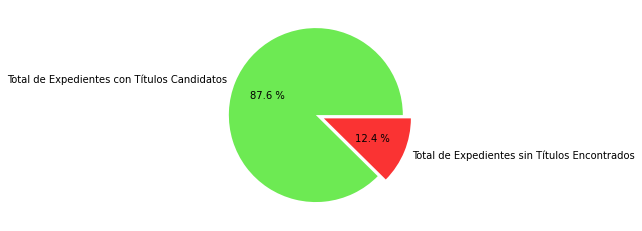

In [375]:
# Creo un grafico de torta
import matplotlib.pyplot as plt

totalExp = len(dfSinTitulosEncontrados)
totalExpSinEncontrar = len(dfSinTitulos)

# Creación de grafico de torta de la cantidad de expedientes con títulos en mayúsculas sobre el total de expedientes.
cantExp = [totalExp, totalExpSinEncontrar]
nombreTitulos = ['Total de Expedientes con Títulos Candidatos', 'Total de Expedientes sin Títulos Encontrados']
colores = ['#6DEA53','#FA3333']
desfase=(0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt.show()

### Títulos con números romanos en minusculas. Escritos en mayusculas y minusculas.

In [376]:
# Busca títulos en mayusculas o minusculas que comienzan con numeros romanos en minuscula.
def buscarTitulosRomanosMinusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(i{1,3}|iv|v|vi{1,3}|ix|x)[.)-]+[A-Za-z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []
    #i=1
    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8 and len(m.group().split()) <= 5:# and re.findall(str(i),m.group()):
            titulosMayusculasEncontrados.append(m.group())
            #i=i+1

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosRomanosMinusculas=[]
for expediente in dfSinTitulosEncontrados['expediente']:
    if len(buscarTitulosRomanosMinusculas(expediente)) > 3:
        titulosRomanosMinusculas.append(buscarTitulosRomanosMinusculas(expediente))

In [377]:
dfTitulosMayusculas.to_excel('titulos_mayusculas.xlsx', index=False)

# Expedientes con titulos en mayusculas sobre el total de expedientes

In [378]:
print(f'''
Cantidad de expediente que tienen titulos en mayusculas:        {len(dfTitulosMayusculas)}
Cantidad de expedientes que no tienen titulos en mayusculas:    {len(dfLimpio) - len(dfTitulosMayusculas)}  
Total de expedientes: {len(dfLimpio)} ''')


Cantidad de expediente que tienen titulos en mayusculas:        1184
Cantidad de expedientes que no tienen titulos en mayusculas:    2007  
Total de expedientes: 3191 


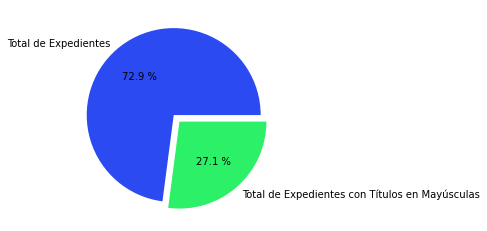

In [379]:
# Creo un grafico de torta
import matplotlib.pyplot as plt

totalExp = len(dfLimpio)
totalExpMayusculas = len(dfTitulosMayusculas)

# Creación de grafico de torta de la cantidad de expedientes con títulos en mayúsculas sobre el total de expedientes.
cantExp = [totalExp, totalExpMayusculas]
nombreTitulos = ['Total de Expedientes', 'Total de Expedientes con Títulos en Mayúsculas']
colores = ['#2C4AF1','#2CF168']
desfase=(0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt.show()

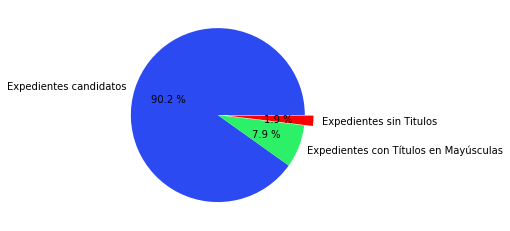

In [380]:
# Creo un grafico de torta expedientes por tipo de busqueda.
import matplotlib.pyplot as plt

totalCandidatos = len(dfTitulosCandidatos)
totalExpMayusculas = len(dfTitulosMayusculas)
totalSinTitulos = len(dfSinTitulos)

# Creación de grafico de torta de la cantidad de expedientes con títulos en mayúsculas sobre el total de expedientes.
cantExp = [totalCandidatos, totalExpMayusculas, totalSinTitulos]
nombreTitulos = ['Expedientes candidatos', 'Expedientes con Títulos en Mayúsculas', 'Expedientes sin Titulos']
colores = ['#2C4AF1','#2CF168', 'r']
desfase=(0,0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt.show()

## Titulos y ubicacion

In [381]:
# Encontrar la ubicacion del titulo en el documento
titulosPosicion=[]

for titulo in titulosMayusculas[0]:
    inicioTitulo = dfLimpio[0].index(titulo)
    palabrasPorTitulo = len(titulo)
    finalTitulo = inicioTitulo + palabrasPorTitulo
    titulosPosicion.append((titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

pprint(titulosPosicion)

[('I-PROEMIO:', 161, 171, 10),
 ('II-ANTECEDENTES DE INTERES MEDICO-LEGAL:', 690, 730, 40),
 ('III-EXAMEN FISICO DEL ACTOR:', 1646, 1674, 28),
 ('IV-CONSIDERACIONES MEDICO-LEGALES:', 9140, 9174, 34),
 ('VII-CONCLUSIONES.', 19171, 19188, 17),
 ('VII-INCAPACIDAD:', 20974, 20990, 16),
 ('VIII CONTESTACION DE LOS PUNTOS DE PERICIA:', 21297, 21340, 43),
 ('IX-PETITORIO:', 21411, 21424, 13)]


In [382]:
# Creo una variable que contiene el párrafo de un título en particular
parrafoConsideraciones = dfLimpio[0][171:690]
#parrafoConsideraciones = general(parrafoConsideraciones)
parrafoConsideraciones = remove_stops(parrafoConsideraciones)
parrafoConsideraciones = limpiar_palabras(parrafoConsideraciones)
pprint(parrafoConsideraciones)
pprint(f'LONGITUD DE PALABRAS: {len(parrafoConsideraciones.split())}')

('juez nacional hortas maria andrea perito medico oficio siguientes autos '
 'domicilio constituido calle austria piso dpto capital domicilio electronico '
 'cumplimiento dispuesto referente presentes autos despues haber examinado '
 'dijo boiero franco ivan tomaron momento examen clinico actual consideraron '
 'capacidad generica particular puntos pericia solicitados partes')
'LONGITUD DE PALABRAS: 44'


# DATAFRAME DE UBICACIÓN DE TÍTULOS

In [383]:
# Encontrar la ubicacion del titulo en el documento
titulosPosicion1=[]
expedientesRaros = []
tipo='encontrado'
for i in range(len(dfLimpio)):
    for titulo in titulosMayusculas[i]:
        inicioTitulo = dfLimpio[i].index(titulo)
        caracteres = len(titulo)
        titulo = re.sub('[\n\.):-]',' ',titulo)
        titulo = limpiar_palabras(titulo)
        palabrasPorTitulo = len(titulo.split())
        finalTitulo = inicioTitulo + caracteres
        #if palabrasPorTitulo > 0:
        titulosPosicion1.append((i, tipo, titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))
        #else:
         
        #   expedientesRaros.append((i, str(dfLimpio[i])))

dfUbicacionTitulos = pd.DataFrame(titulosPosicion1,columns=['id','tipo','titulo','inicio','fin','longitud'])

In [384]:
#dfUbicacionTitulos = dfUbicacionTitulos.drop(dfUbicacionTitulos[dfUbicacionTitulos['titulo'] ==''].index)
#Aplicando esto, de 5776 filas, se reduce a 5390. 

In [385]:
#pprint(dfLimpio[488][9541:])
#pprint(dfLimpio[1736])

In [386]:
#pprint(df1[3639])
#df.expediente[3639]

## Calculo de la longitud de los parrafos

In [387]:
# Calculo la longitud de caracteres de parrafos
def longitud_parrafos(ubicacion, original):
    parrafos=[]
    for i in range(len(ubicacion)):
        if i < len(ubicacion)-1:
            inicio = ubicacion['inicio'][i]
            fin = ubicacion['inicio'][i+1]
            idDf = ubicacion['id'][i]
            if (fin-inicio) > 0:
                parrafo = original[idDf][inicio:fin]
                parrafo = remove_stops(parrafo)
                parrafo = general(parrafo)
               
                #parrafo = limpiar_palabras(parrafo)
                caracteres = len(parrafo.split())
                parrafos.append(caracteres)
            else:
                parrafo = original[idDf][inicio:]
                parrafo = general(parrafo)
                parrafo = remove_stops(parrafo)
                parrafo = limpiar_palabras(parrafo)
                caracteres = len(parrafo.split())
                parrafos.append(caracteres)
    return parrafos

longitudP = longitud_parrafos(dfUbicacionTitulos, dfLimpio)

In [388]:
dfUbicacionTitulos['longitud_parrafo'] = pd.DataFrame(longitudP)

In [389]:
dfUbicacionTitulos.longitud_parrafo[5775] = 112
dfUbicacionTitulos.longitud_parrafo[5389] = 112

C:\Users\gasto\AppData\Local\Temp\ipykernel_9620\2840726199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUbicacionTitulos.longitud_parrafo[5775] = 112
C:\Users\gasto\AppData\Local\Temp\ipykernel_9620\2840726199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfUbicacionTitulos.longitud_parrafo[5389] = 112


In [390]:
dfUbicacionTitulos['titulo'].to_csv('titulosEncontrados.csv',index=False)
dfUbicacionTitulos.to_csv('df_TitulosEncontrados.csv',index=False)
dfUbicacionTitulos.to_excel('df_TitulosEncontrados.xlsx',index=False)

In [391]:
dfTitulosCandidatos.to_csv('df_titulosCandidatos.csv',index=False)
dfTitulosCandidatos.to_excel('df_titulosCandidatos.xlsx', index=False)
dfTitulosCandidatos['titulo'].to_csv('titulosCandidatos.csv',index=False)

In [392]:
dfUbicacionTitulos['longitud'].describe()

count    5671.000000
mean        2.254629
std         1.357344
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: longitud, dtype: float64

In [393]:
#pprint(dfLimpio[1736][14170:])

In [394]:
# Creo una lista de parrafos
def extraer_parrafos(ubicacion, original):
    parrafos=[]
    for i in range(len(ubicacion)):
        if i < len(ubicacion)-1:
            inicio = ubicacion['fin'][i]
            fin = ubicacion['inicio'][i+1]
            idDf = ubicacion['id'][i]
            if (fin-inicio) > 0:
                parrafo = original[idDf][inicio:fin]
                caracteres = general(parrafo)
                caracteres = remove_stops(caracteres)
                caracteres = limpiar_palabras(caracteres)
                caracteres = caracteres.split(sep=' ')
                parrafos.append(caracteres)
            else:
                parrafo = original[idDf][inicio:]
                caracteres = general(parrafo)
                caracteres = remove_stops(caracteres)
                caracteres = limpiar_palabras(caracteres)
                caracteres = caracteres.split(sep=' ')
                parrafos.append(caracteres)
    return parrafos

parrafos = extraer_parrafos(dfUbicacionTitulos,dfLimpio)

In [395]:
#dfLimpio[0][172:690]#161:690
#parrafos[0]

In [396]:
print(f'LONGITUD DE PALABRAS: {len(parrafos[0])}')

LONGITUD DE PALABRAS: 44


In [397]:
#parrafos[0]

In [398]:
#df['expediente'][165]

# CREACION DE DOCUMENTO HTML
## MUESTRO LOS TITULOS Y PARRAFOS ENCONTRADOS

In [399]:
# Creamos un dataframe para colocar el salto de linea en formato HTML
dfLimpioHTML = dfLimpio.apply(str)
def limpiarTextoHTML(text):
    text = text.strip().replace('\n','<br>')
    return text

dfLimpioHTML = dfLimpioHTML.apply(limpiarTextoHTML)
parrafoConsideraciones = limpiarTextoHTML(parrafoConsideraciones)

In [400]:
colors = {
    'procedimientos': '#cd5c5c',
    'cuerpos': '#99ccff',
    'afecciones': '#ffa500'
}

body = f'''
        <p>
        {dfLimpioHTML[1]}
        </p>
        <br>
        '''
body = body.replace(parrafoConsideraciones,f'<span style="background-color: #99ccff">{parrafoConsideraciones}</span>')
for titulo in titulosMayusculas[1]:
    body = body.replace(titulo,f'<span style="background-color: #cd5c5c">{titulo}</span>')
with open('parrafos.html','w', encoding="utf-8") as f:
    f.write(body)

# Gráfico de frecuencia de palabras por párrafo. Histograma.

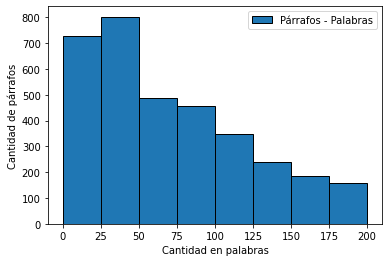

In [401]:
import matplotlib.pyplot as plt

longParrafos = dfUbicacionTitulos['longitud_parrafo']
bins1 = [0, 25, 50, 75, 100, 125, 150, 175, 200] #, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000

plt.hist(longParrafos, bins1, edgecolor='black', label='Párrafos - Palabras')
plt.xlabel('Cantidad en palabras')
plt.ylabel('Cantidad de párrafos')
plt.legend()
plt.show()

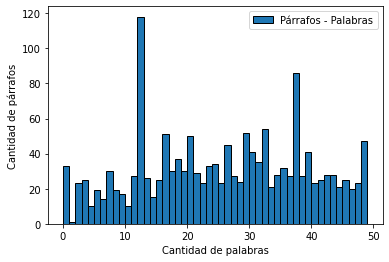

In [402]:
import matplotlib.pyplot as plt

longParrafos = dfUbicacionTitulos['longitud_parrafo']
#bins2 = [0,50, 100,150, 200,250, 300,350, 400,450, 500,550, 600,650, 700,750, 800,850, 900,950, 1000]#[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] #, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000

plt.hist(longParrafos, bins=range(0,50,1),ec='k',label='Párrafos - Palabras', align='mid')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Cantidad de párrafos')
plt.legend()
#plt.axis([1,100,1,300])
plt.show()
# total de parrafos 5775
# limpiar titulos con parrafos de menos de 10 palabras.

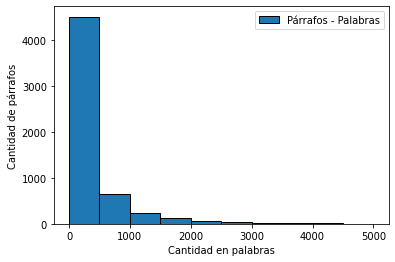

In [403]:
import matplotlib.pyplot as plt

longParrafos = dfUbicacionTitulos['longitud_parrafo']
bins3 = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

plt.hist(longParrafos, bins3, edgecolor='black', label='Párrafos - Palabras')
plt.legend()
plt.xlabel('Cantidad en palabras')
plt.ylabel('Cantidad de párrafos')
plt.show()

# Gráfico de frecuencia de palabras por párrafo. BoxPlot.

In [404]:
dfUbicacionTitulosLimpio = dfUbicacionTitulos.drop(dfUbicacionTitulos[dfUbicacionTitulos['titulo'] ==''].index)
dfUbicacionTitulosLimpio = dfUbicacionTitulos.drop(dfUbicacionTitulos[dfUbicacionTitulos['longitud_parrafo'] > 1000].index)
longParrafosBox = dfUbicacionTitulosLimpio['longitud_parrafo']

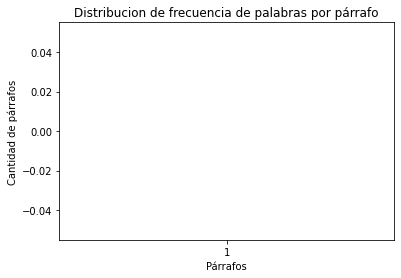

In [405]:
plt.boxplot(longParrafosBox)
plt.title('Distribucion de frecuencia de palabras por párrafo')
plt.xlabel('Párrafos')
plt.ylabel('Cantidad de párrafos')
plt.show()

In [406]:
longParrafosBox.describe()

count    5170.000000
mean      204.570793
std       227.318345
min         0.000000
25%        40.000000
50%       107.000000
75%       293.000000
max       999.000000
Name: longitud_parrafo, dtype: float64

In [407]:
longParrafosBox.max()

999.0

<AxesSubplot:>

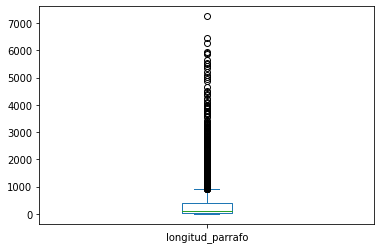

In [408]:
dfUbicacionTitulos['longitud_parrafo'].plot(kind='box')

# TF-IDF

In [409]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [410]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("spanish")

In [411]:

# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [412]:
# #not super pythonic, no, not at all.
# #use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in dfUbicacionTitulos['titulo']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [413]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 12786 items in vocab_frame


In [414]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=25,
                                 min_df=100,
                                 use_idf=True, ngram_range=(1,4))# tokenizer=tokenize_and_stem

tfidf_matrix = tfidf_vectorizer.fit(dfUbicacionTitulos['titulo']) #fit the vectorizer to synopses
tfidf_final = tfidf_matrix.transform(dfTitulosCandidatos['titulo'])
print(tfidf_final.shape)

(13445, 25)


In [415]:
terms = tfidf_vectorizer.get_feature_names_out()

In [416]:
terms

array(['actor', 'antecedentes', 'antecedentes autos', 'autos', 'clinica',
       'conclusiones', 'consideraciones', 'consideraciones medico',
       'consideraciones medico legales', 'contestacion',
       'contestacion puntos', 'examen', 'historia', 'historia clinica',
       'interes', 'interes medico', 'legal', 'legales', 'medico',
       'medico legal', 'medico legales', 'pericia', 'petitorio', 'puntos',
       'puntos pericia'], dtype=object)

## CountVectorizer

In [417]:
from sklearn.feature_extraction.text import CountVectorizer

coun_vect = CountVectorizer()
count_matrix = coun_vect.fit(dfUbicacionTitulos['titulo'])
count_final = count_matrix.transform(dfTitulosCandidatos['titulo'])
count_array = count_final.toarray()


In [418]:
count_matrix.get_feature_names_out()

array(['aaec', 'abdomen', 'abodarje', ..., 'wiberg', 'wiuerg', 'zambrano'],
      dtype=object)

# PRUEBAS

In [419]:
# Se unen los dos dataframes en uno solo: Guardo los titulos encontrados y titulos candidatos en un solo dataframe
dfTitulos = pd.concat([dfUbicacionTitulos, dfTitulosCandidatos], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
dfTitulos = dfTitulos[['id', 'tipo', 'titulo', 'inicio', 'fin', 'longitud']]
dfTitulos.columns = ['id', 'tipo', 'titulo', 'inicio', 'fin', 'longitud']

In [420]:
# Guardo los titulos encontrados y titulos candidatos en un solo dataframe y lo convierot a un archivo .csv
dfTitulos.to_csv('dftitulos.csv',index=False)

In [421]:
def limpiar_tokenizar(text):
    tokenizado=[]
    for titulo in text:
        # Tokenización por palabras individuales
        tokenizado.append(titulo.split(sep = ' '))
    return(tokenizado)

In [422]:
dfTitulos['titulo_tokenizado'] = limpiar_tokenizar(dfTitulos['titulo'])
dfTitulos[['titulo', 'titulo_tokenizado']].head()

,titulo,titulo_tokenizado
0,proemio,[proemio]
1,antecedentes interes medico legal,"[antecedentes, interes, medico, legal]"
2,examen fisico actor,"[examen, fisico, actor]"
3,consideraciones medico legales,"[consideraciones, medico, legales]"
4,conclusiones,[conclusiones]


In [423]:
# Unnest de la columna titulo_tokenizado
# ==============================================================================
titulos_tidy = dfTitulos.explode(column='titulo_tokenizado')
titulos_tidy = titulos_tidy.drop(columns='titulo')
titulos_tidy = titulos_tidy.drop(columns='longitud')
titulos_tidy = titulos_tidy.rename(columns={'titulo_tokenizado':'token'})
titulos_tidy = titulos_tidy.drop(titulos_tidy[titulos_tidy['token'] ==''].index)
titulos_tidy.head(3)

,id,tipo,inicio,fin,token
0,0,encontrado,161,171,proemio
1,0,encontrado,690,730,antecedentes
1,0,encontrado,690,730,interes


## Frecuencia de título

In [424]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por títulos')
print('--------------------------')
titulos_tidy.groupby(by='tipo')['token'].count()

--------------------------
Palabras totales por títulos
--------------------------


tipo
candidato     28043
encontrado    12786
Name: token, dtype: int64

In [425]:
# Palabras distintas por títulos
# ==============================================================================
print('----------------------------')
print('Palabras distintas por títulos')
print('----------------------------')
titulos_tidy.groupby(by='tipo')['token'].nunique()

----------------------------
Palabras distintas por títulos
----------------------------


tipo
candidato     3275
encontrado    1026
Name: token, dtype: int64

In [426]:
# Longitud media y desviación de los titulos de cada tipo
# ==============================================================================
temp_df = pd.DataFrame(titulos_tidy.groupby(by = ["tipo", "id"])["token"].count())
temp_df.reset_index().groupby("tipo")["token"].agg(['mean', 'std'])

,mean,std
tipo,,
candidato,16.399415,16.980976
encontrado,11.118261,8.571205


In [427]:
# Top 5 títulos más repetidos por tipo
# ==============================================================================
print('Top 5 títulos más repetidos por tipo')
titulos_tidy.groupby(['tipo','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('tipo') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

Top 5 títulos más repetidos por tipo


tipo            token  count
tipo                                               
candidato  2748   candidato        respuesta    635
           1237   candidato           examen    612
           1639   candidato          informe    542
           1937   candidato           medico    518
           617    candidato  consideraciones    389
encontrado 3866  encontrado           medico    827
           4083  encontrado           puntos    609
           3469  encontrado     conclusiones    576
           3991  encontrado          pericia    537
           3372  encontrado     antecedentes    485

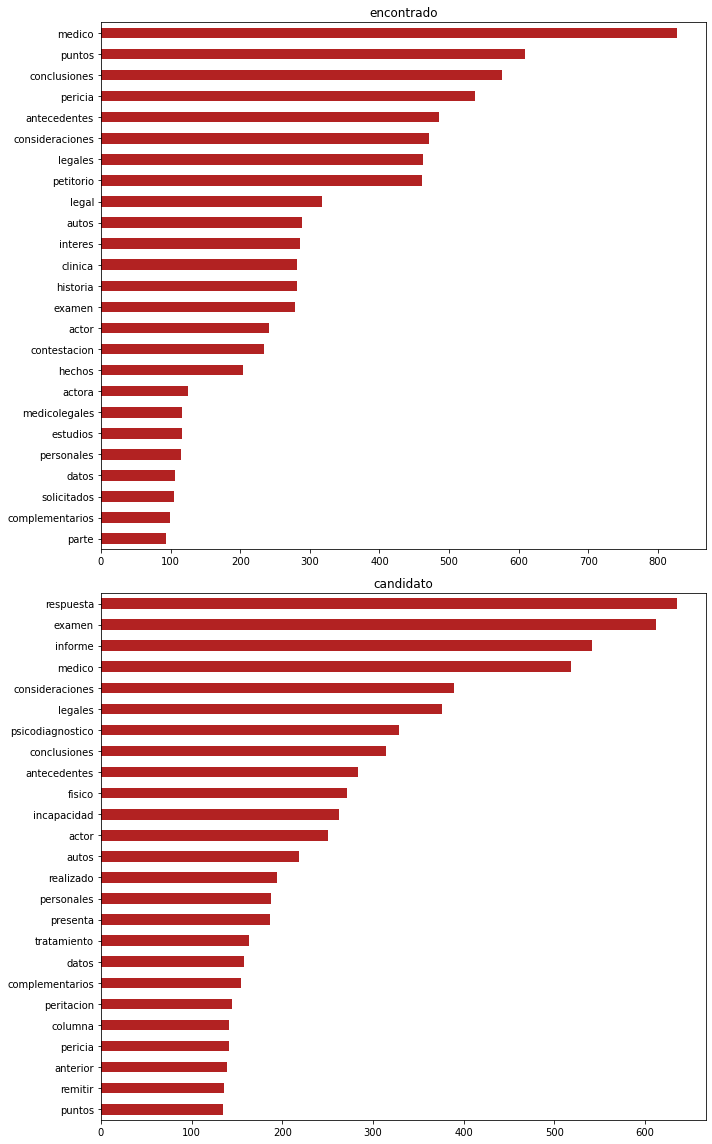

In [428]:
# Top 10 títulos por tipo 
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(10, 16))
for i, tipo in enumerate(titulos_tidy.tipo.unique()):
    df_temp = titulos_tidy[titulos_tidy.tipo == tipo]
    counts  = df_temp['token'].value_counts(ascending=False).head(25)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(tipo)

fig.tight_layout()

In [429]:
# Pivotado de títutlos por tipo y token.
# ==============================================================================
titulos_pivot = titulos_tidy.groupby(["tipo","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="tipo", values= "count")
titulos_pivot.columns.name = None

In [430]:
titulos_pivot.encontrado.index[0]

'aacs'

In [431]:
for i, count in enumerate(titulos_pivot.encontrado):
    if titulos_pivot.candidato[i] > 80 and count > 80:
        print(titulos_pivot.index[i])

actor
actora
antecedentes
autos
complementarios
conclusiones
consideraciones
datos
estudios
examen
hechos
incapacidad
interes
legal
legales
medico
pericia
personales
petitorio
puntos


In [432]:
# Test de correlación (coseno) por títulos candidato y título encontrado
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return distancia

matriz_corr = titulos_pivot.corr(method=similitud_coseno)

In [433]:
print('Correlación entre tipos de títulos')
matriz_corr

Correlación entre tipos de títulos


,candidato,encontrado
candidato,1.000000,0.357399
encontrado,0.357399,1.000000


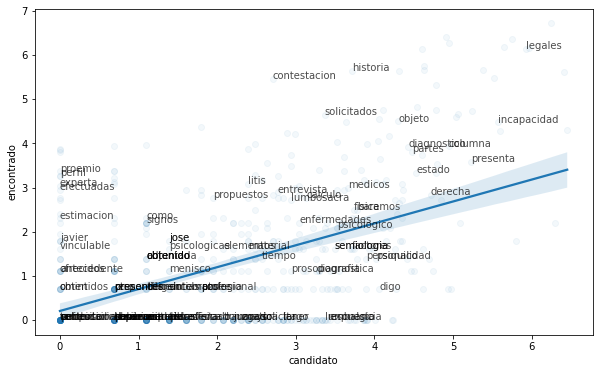

In [434]:
import seaborn as sns

# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(10, 6))
temp = titulos_pivot.dropna()
sns.regplot(
    x  = np.log(temp.candidato),
    y  = np.log(temp.encontrado),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.candidato[i]), np.log(temp.encontrado[i])),
        alpha = 0.7
    )

In [435]:
# Número de palabras comunes en títulos encotnrados y candidatos.
# ==============================================================================
titulo_encontrado = set(titulos_tidy[titulos_tidy.tipo == 'encontrado']['token'])
titulo_candidato = set(titulos_tidy[titulos_tidy.tipo == 'candidato']['token'])


print(f"Palabras comunes entre títulos encontrados y títulos candidatos: {len(titulo_encontrado.intersection(titulo_candidato))}")

Palabras comunes entre títulos encontrados y títulos candidatos: 575


In [436]:
nuevosTitulosEncontrados = []
for encontrado in titulo_encontrado:
    for candidato in titulo_candidato:
        if encontrado == candidato :
            nuevosTitulosEncontrados.append(candidato)

In [437]:
# Cálculo del log of odds ratio de cada palabra títulos encontrados y títulos candidatos
# ==============================================================================
# Pivotaje y despivotaje
titulos_pivot = titulos_tidy.groupby(["tipo","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="tipo", values= "count")

titulos_pivot = titulos_pivot.fillna(value=0)
titulos_pivot.columns.name = None

titulos_unpivot = titulos_pivot.melt(value_name='n', var_name='tipo', ignore_index=False)
titulos_unpivot = titulos_unpivot.reset_index()

# Selección de los títlos encontrados y candidatos. 
titulos_unpivot = titulos_unpivot[titulos_unpivot.tipo.isin(['encontrado', 'candidato'])]

# Se añade el total de palabras de cada titulo.
titulos_unpivot = titulos_unpivot.merge(
                    titulos_tidy.groupby('tipo')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'tipo'
                 )

# Cálculo de odds y log of odds de cada palabra
titulos_logOdds = titulos_unpivot.copy()
titulos_logOdds['odds'] = (titulos_logOdds.n + 1) / (titulos_logOdds.N + 1)
titulos_logOdds = titulos_logOdds[['token', 'tipo', 'odds']] \
                    .pivot(index='token', columns='tipo', values='odds')
titulos_logOdds.columns.name = None

titulos_logOdds['log_odds']     = np.log(titulos_logOdds.encontrado/titulos_logOdds.candidato)
titulos_logOdds['abs_log_odds'] = np.abs(titulos_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser título encontrado. Esto es así porque el ratio sea ha
# calculado como encontrado/candidato.
titulos_logOdds['tipo_frecuente'] = np.where(titulos_logOdds.log_odds > 0,
                                              "encontrado",
                                              "candidato"
                                    )

In [438]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadas en títulos encontrados y tíulos candidatos')
print('-----------------------------------')
titulos_logOdds.sort_values('abs_log_odds', ascending=False).head(30)

-----------------------------------
Top 10 palabras más diferenciadas en títulos encontrados y tíulos candidatos
-----------------------------------


,candidato,encontrado,log_odds,abs_log_odds,tipo_frecuente
token,,,,,
integral,0.000036,0.004145,4.755638,4.755638,encontrado
realizado,0.006953,0.000078,-4.487654,4.487654,candidato
auxiliares,0.000036,0.003050,4.448907,4.448907,encontrado
discusion,0.000036,0.003050,4.448907,4.448907,encontrado
remitir,0.004885,0.000078,-4.134635,4.134635,candidato
contestar,0.000036,0.002190,4.117550,4.117550,encontrado
llevados,0.000071,0.003832,3.984019,3.984019,encontrado
sido,0.004172,0.000078,-3.976828,3.976828,candidato
cabo,0.000071,0.003754,3.963400,3.963400,encontrado


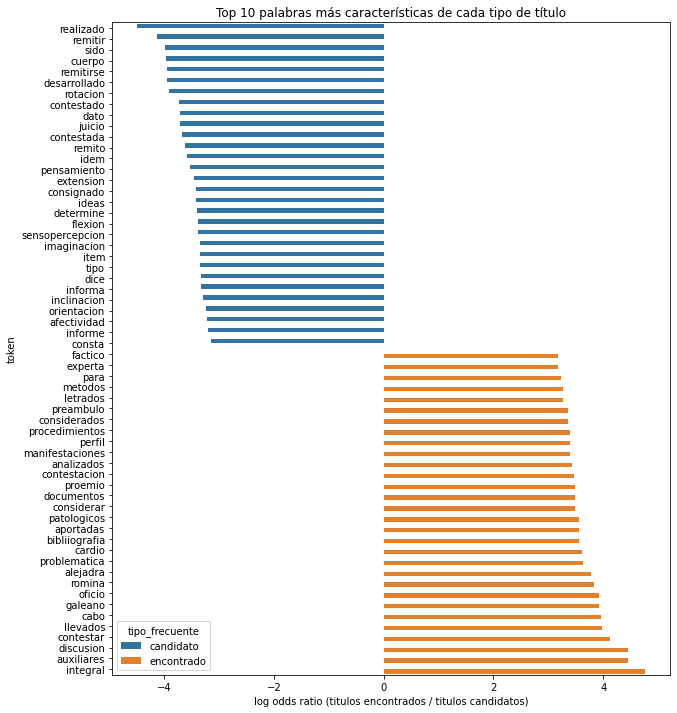

In [439]:
# Top 15 palabras más características de cada tipo de título
# ==============================================================================

top_30 = titulos_logOdds[['log_odds', 'abs_log_odds', 'tipo_frecuente']] \
        .groupby('tipo_frecuente') \
        .apply(lambda x: x.nlargest(30, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(10, 12))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'tipo_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 10 palabras más características de cada tipo de título')
ax.set_xlabel('log odds ratio (titulos encontrados / titulos candidatos)');

In [440]:
len(longParrafos)

5671

In [463]:
dfSinTitulosEncontrados['expediente'][2185][156:]

KeyError: 2185

In [450]:
dfExpTitulosCandidatos.expediente[308][7502:]

'neamente incorporan ejercicios isometricos suaves elevacion pierna La mayor parte pacientes suelen recuperar funcion programa sencillo ejercicios ningun bajo impacto, inicialmente centrados bicicleta estatica. En casos remodelacion meniscal recuperacion motora rapida norma. A pesar observaciones, estudios demostrado fortaleza pierna reduce tras realizar remodelacion meniscal, especialmente afectacion inicial funcion extensora rodilla. (1) De hecho, estudio demostro recuperacion funcional niveles preoperatorios posible, cabo 4 6 semanas, funcion cuadriceps completa realizar fisioterapia queda mas debil contralateral mas 12 semanas tras realizar remodelacion meniscal. (2) Se demostrado musculos extensores rodilla pierden 20% 40% fuerza flexores alrededor 20% semanas realizada remodelacion. (3) El mayor problema defectos que, unicamente defecto residual 10% extensores flexores rodilla, aumenta riesgo lesion misma.(4) Por tanto, si existe programa fisioterapia intensiva supervisada, pacie